# Amazon Fine Food Reviews
practicing on NLP data sets based on tutorial by Rob Mulla

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import nltk



In [52]:
df = pd.read_csv("data/Reviews.csv").sample(500, random_state = 42)


### Exploratory Analysis

In [53]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
165256,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
231465,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
427827,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
433954,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
70260,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...


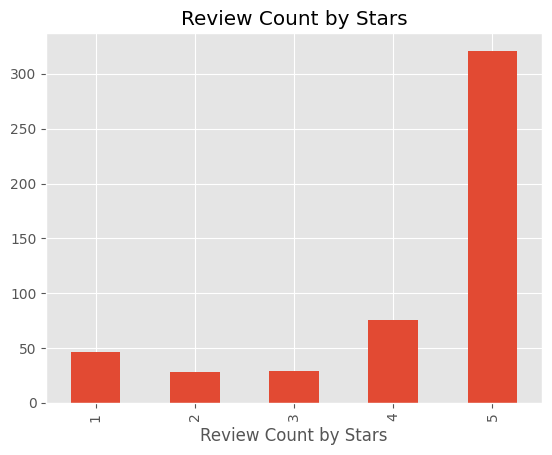

In [54]:
df["Score"].value_counts().sort_index().plot(kind = "bar", title = "Review Count by Stars").set_xlabel("Review Count by Stars")
plt.show()

Most reviews are positive reviews

### VADER Sentiment Analysis

In [55]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [57]:
res ={}

for i,row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [58]:
vaders_result = pd.DataFrame(res).T
vaders_result = vaders_result.reset_index().rename(columns={'index' : 'Id'})
vaders_result = vaders_result.merge(df, how="left")

In [59]:
vaders_result.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,165257,0.000,0.768,0.232,0.9684,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
1,231466,0.089,0.766,0.144,0.7920,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
2,427828,0.000,0.880,0.120,0.4588,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
3,433955,0.009,0.827,0.163,0.9923,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
4,70261,0.089,0.719,0.191,0.9421,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...


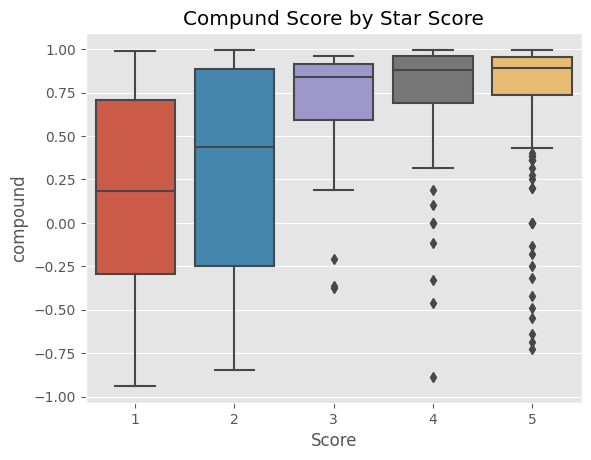

In [61]:
ax = sns.boxplot(data = vaders_result, x = 'Score', y='compound').set_title('Compund Score by Star Score')

plt.show()

Compound score increases as star rating increases, as expected

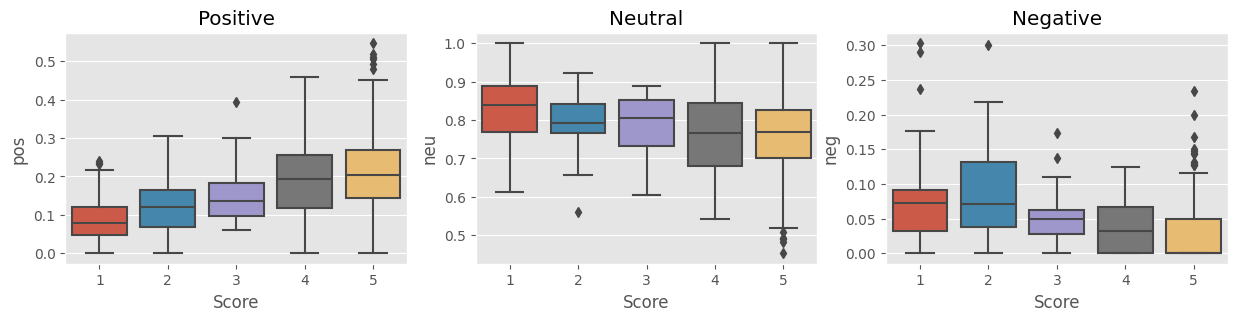

In [62]:
fig, axs = plt.subplots(1,3, figsize = (15,3))
sns.boxplot(data = vaders_result, x='Score', y='pos', ax = axs[0])
sns.boxplot(data = vaders_result, x='Score', y='neu', ax = axs[1])
sns.boxplot(data = vaders_result, x='Score', y='neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

positive score increases as star rating increases. neutral score more or less stays the same, slightly decreasing as star rating increases. negative score decreases as star rating increases. 

### Roberta Pretrained Model

In [63]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [64]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [65]:
def roberta_polarity_scores(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    
    return scores_dict

In [66]:
res = {}

for i,row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_res = sia.polarity_scores(text)
        
        roberta_res = roberta_polarity_scores(text)
        both = {**vader_res, **roberta_res}
        res[myid] = both
        
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 184619
Broke for id 31994
Broke for id 171315
Broke for id 149020


In [72]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index' : 'Id'})
results_df.rename(columns={'neg':'vader_neg', 'neu':'vader_neu', 'pos':'vader_pos'})
results_df = results_df.merge(df, how="left")


In [71]:
results_df.head()

,Id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,165257,0.000,0.768,0.232,0.9684,0.004572,0.032567,0.962861,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
1,231466,0.089,0.766,0.144,0.7920,0.003145,0.013015,0.983840,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
2,427828,0.000,0.880,0.120,0.4588,0.501474,0.422844,0.075682,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
3,433955,0.009,0.827,0.163,0.9923,0.058795,0.318585,0.622620,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
4,70261,0.089,0.719,0.191,0.9421,0.010467,0.048259,0.941274,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...
